<a href="https://colab.research.google.com/github/Aiyon860/Ace-Leetcode/blob/main/Jobsheet_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nama: Daniel Adi Pratama
# NIM: 4.33.23.0.07
# Kelas: TI-2A
# Materi: Segmentasi Gambar

## Praktikum 1: Segmentasi Menggunakan Thresholding Global dan Otsu

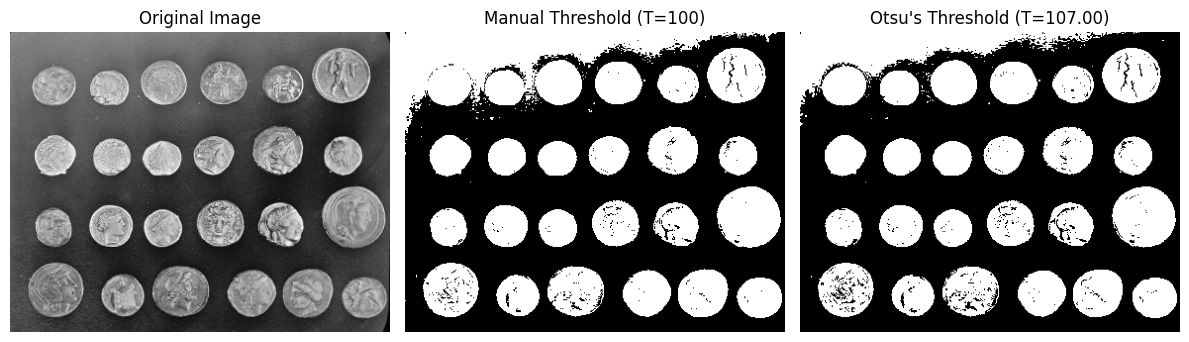

Nilai threshold Otsu yang ditemukan: 107


In [1]:
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_ubyte
from skimage.color import rgb2gray

# 1. Memuat citra (contoh: coins)
image_coins = data.coins()  # Citra sudah grayscale

# 2. Thresholding Global (manual)
# Tentukan nilai ambang manual, misal 100
thresh_manual = 100
binary_manual = image_coins > thresh_manual

# 3. Thresholding Otsu
thresh_otsu = filters.threshold_otsu(image_coins)
binary_otsu = image_coins > thresh_otsu

# 4. Visualisasi Hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_manual, cmap=plt.cm.gray)
ax[1].set_title(f'Manual Threshold (T={thresh_manual})')
ax[1].axis('off')

ax[2].imshow(binary_otsu, cmap=plt.cm.gray)
ax[2].set_title(f"Otsu's Threshold (T={thresh_otsu:.2f})")
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Menampilkan nilai threshold Otsu
print(f"Nilai threshold Otsu yang ditemukan: {thresh_otsu}")

## Praktikum 2: Segmentasi Menggunakan Region Growing

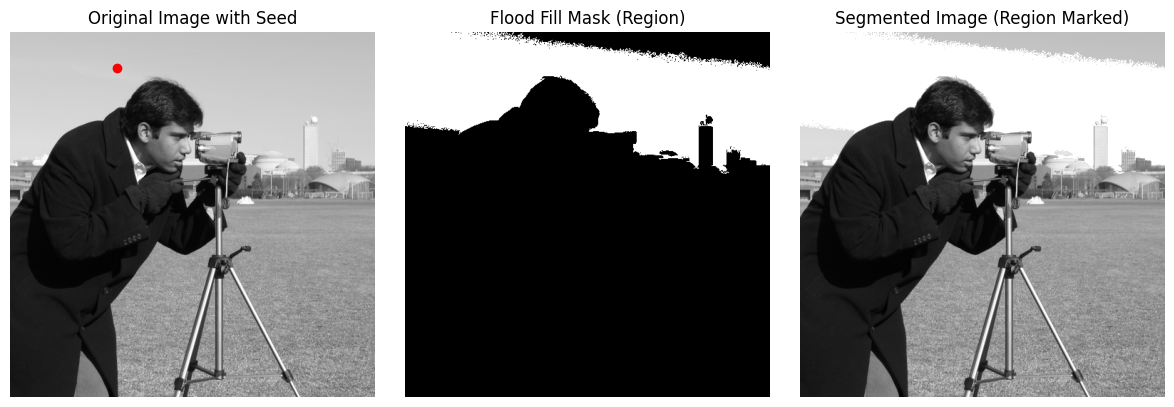

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, color

# 1. Memuat citra (contoh: camera)
image_camera = data.camera()

# 2. Tentukan titik 'seed' (benih)
# Misal, kita pilih titik di area langit (misal, koordinat y=50, x=150)
seed_point = (50, 150)

# 3. Terapkan algoritma flood fill (mirip region growing)
# 'tolerance' menentukan seberapa besar perbedaan intensitas yang diizinkan
flood_mask = segmentation.flood(image_camera, seed_point, tolerance=10)

# 4. Buat citra tersegmentasi (tandai region yang 'tumbuh')
segmented_image = np.copy(image_camera)
segmented_image[flood_mask] = 255  # Tandai region dengan warna putih

# 5. Visualisasi Hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_camera, cmap=plt.cm.gray)
ax[0].plot(seed_point[1], seed_point[0], 'ro')  # Tandai seed point
ax[0].set_title('Original Image with Seed')
ax[0].axis('off')

ax[1].imshow(flood_mask, cmap=plt.cm.gray)
ax[1].set_title('Flood Fill Mask (Region)')
ax[1].axis('off')

ax[2].imshow(segmented_image, cmap=plt.cm.gray)
ax[2].set_title('Segmented Image (Region Marked)')
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Praktikum 3: Segmentasi Citra Berwarna Menggunakan K-Means Clustering

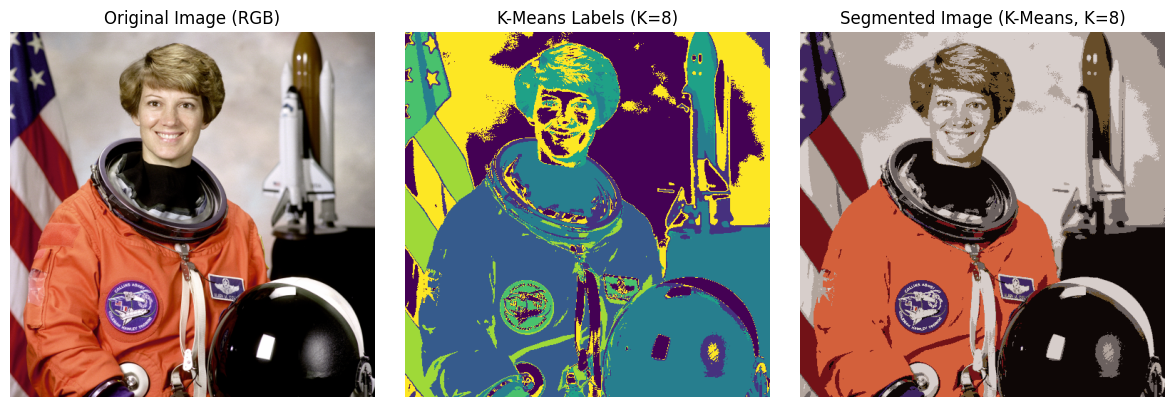

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb
import warnings

# 1. Memuat citra berwarna (contoh: astronaut)
image_astro = data.astronaut()
# Konversi ke float untuk perhitungan
image_astro_float = image_astro.astype(float) / 255.0

# 2. Reshape citra menjadi array piksel [jumlah_piksel, jumlah_fitur]
# Fitur bisa RGB atau Lab. Ruang warna Lab seringkali lebih baik untuk persepsi warna.
# Konversi ke Lab
image_lab = rgb2lab(image_astro_float)
rows, cols, dims = image_lab.shape
pixel_features = image_lab.reshape(rows * cols, dims)

# 3. Terapkan K-Means Clustering
# Tentukan jumlah klaster (segmen) yang diinginkan, misal K=4
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)  # n_init='auto' jika versi sklearn baru
# Hiding FutureWarnings related to default value of n_init
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pixel_labels = kmeans.fit_predict(pixel_features)

# 4. Reshape label kembali ke bentuk citra
segmented_labels = pixel_labels.reshape(rows, cols)

# 5. Buat citra tersegmentasi (warnai setiap segmen dengan warna rata-rata klaster)
segmented_image_kmeans = np.zeros_like(image_lab)
centers_lab = kmeans.cluster_centers_
for k in range(n_clusters):
    # Dapatkan piksel yang termasuk klaster k
    cluster_pixels = (pixel_labels == k)
    # Isi piksel tersebut di citra baru dengan warna pusat klaster k
    # Perlu reshape kembali cluster_pixels ke bentuk citra
    mask_k = cluster_pixels.reshape(rows, cols)
    segmented_image_kmeans[mask_k] = centers_lab[k]

# Konversi kembali ke RGB untuk ditampilkan
segmented_image_rgb = lab2rgb(segmented_image_kmeans)

# 6. Visualisasi Hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_astro)
ax[0].set_title('Original Image (RGB)')
ax[0].axis('off')

# Menampilkan label klaster
ax[1].imshow(segmented_labels, cmap='viridis')  # cmap bisa diganti
ax[1].set_title(f'K-Means Labels (K={n_clusters})')
ax[1].axis('off')

# Menampilkan citra hasil segmentasi K-Means
ax[2].imshow(segmented_image_rgb)
ax[2].set_title(f'Segmented Image (K-Means, K={n_clusters})')
ax[2].axis('off')

plt.tight_layout()
plt.show()

## Praktikum 4: Segmentasi Berbasis Tepi Menggunakan Watershed

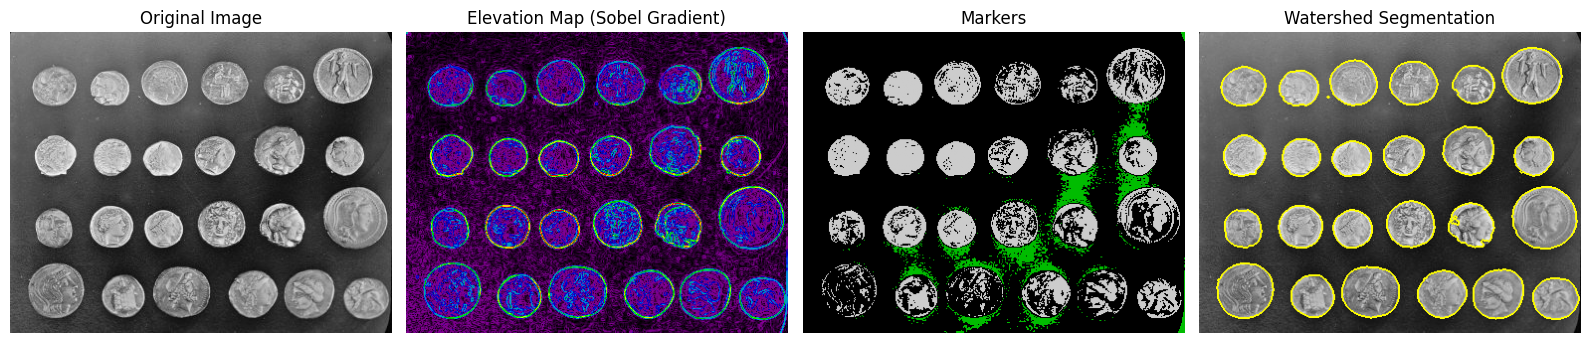

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, morphology, measure
from scipy import ndimage as ndi

# 1. Memuat citra (contoh: coins)
image_coins = data.coins()

# 2. Hitung gradien citra (sebagai 'topografi')
elevation_map = filters.sobel(image_coins)

# 3. Tentukan marker (penanda awal untuk setiap cekungan/objek)
# Kita bisa menggunakan thresholding untuk mendapatkan marker kasar
markers = np.zeros_like(image_coins)
markers[image_coins < 30] = 1  # Marker untuk latar belakang
markers[image_coins > 150] = 2  # Marker untuk objek (koin)

# Atau gunakan marker dari local maxima (lebih canggih)
# from skimage.feature import peak_local_max
# image_max = ndi.maximum_filter(image_coins, size=20, mode='constant')
# coordinates = peak_local_max(image_coins, min_distance=20)
# markers = np.zeros(image_coins.shape, dtype=bool)
# markers[tuple(coordinates.T)] = True
# markers = measure.label(markers)

# 4. Terapkan algoritma Watershed
segmentation_watershed = segmentation.watershed(elevation_map, markers)

# Warnai hasil segmentasi untuk visualisasi
segmented_colored = segmentation.mark_boundaries(image_coins, segmentation_watershed)

# 5. Visualisasi Hasil
fig, axes = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(elevation_map, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Elevation Map (Sobel Gradient)')
ax[1].axis('off')

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Markers')
ax[2].axis('off')

ax[3].imshow(segmented_colored)
ax[3].set_title('Watershed Segmentation')
ax[3].axis('off')

plt.tight_layout()
plt.show()

## Praktikum 5: Perbandingan Visual Hasil Segmentasi

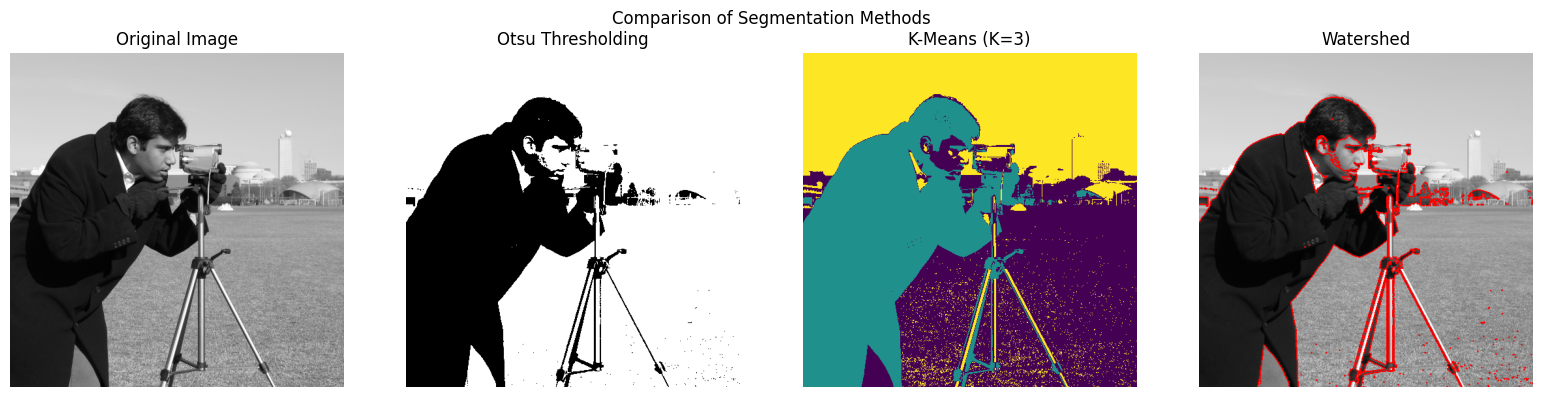

In [17]:
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, img_as_float, color
from sklearn.cluster import KMeans
import numpy as np
import warnings

# 1. Pilih satu citra untuk perbandingan (misal: camera)
image = data.camera()
image_float = img_as_float(image)

# 2. Lakukan beberapa metode segmentasi
# a) Otsu Thresholding
thresh_otsu = filters.threshold_otsu(image)
binary_otsu = image > thresh_otsu

# b) K-Means (misal K=3)
# Reshape untuk K-Means (1 fitur: intensitas)
rows, cols = image.shape
pixel_features = image_float.reshape(rows * cols, 1)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pixel_labels = kmeans.fit_predict(pixel_features)
segmented_kmeans_labels = pixel_labels.reshape(rows, cols)

# c) Watershed (gunakan marker sederhana dari Otsu)
elevation_map = filters.sobel(image)
markers = np.zeros_like(image)
markers[image < thresh_otsu] = 1
markers[image > thresh_otsu] = 2
segmentation_watershed = segmentation.watershed(elevation_map, markers)

# 3. Visualisasi Perbandingan
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_otsu, cmap=plt.cm.gray)
ax[1].set_title('Otsu Thresholding')
ax[1].axis('off')

ax[2].imshow(segmented_kmeans_labels, cmap='viridis')  # Gunakan cmap berbeda untuk label
ax[2].set_title(f'K-Means (K={n_clusters})')
ax[2].axis('off')

# Gunakan mark_boundaries untuk Watershed agar lebih jelas
segmented_watershed_colored = segmentation.mark_boundaries(image_float, segmentation_watershed, color=(1, 0, 0))  # Batas merah
ax[3].imshow(segmented_watershed_colored)
ax[3].set_title('Watershed')
ax[3].axis('off')

plt.suptitle('Comparison of Segmentation Methods')
plt.tight_layout()
plt.show()

## Eksperimen Thresholding: Terapkan metode thresholding Otsu pada citra data.page().

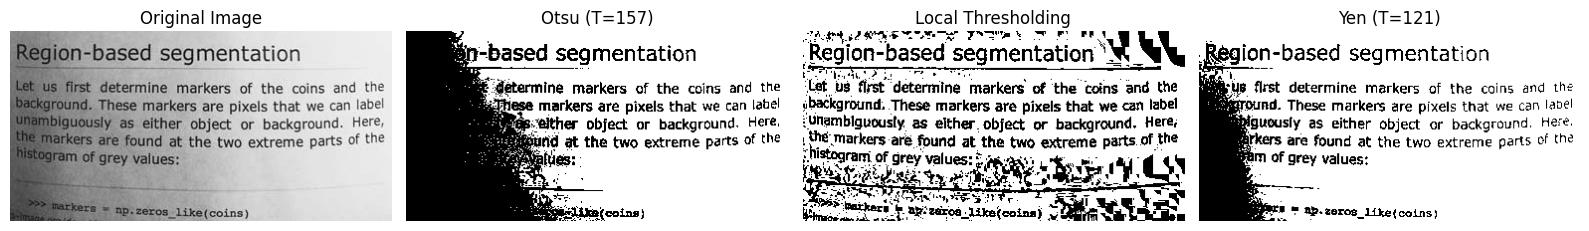

In [19]:
import matplotlib.pyplot as plt
from skimage import data, filters
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_local, threshold_yen

# 1. Load citra dokumen
image_page = data.page()  # Sudah grayscale

# 2. Otsu Thresholding
thresh_otsu = threshold_otsu(image_page)
binary_otsu = image_page > thresh_otsu

# 3. Local Thresholding (adaptif)
block_size = 35
local_thresh = threshold_local(image_page, block_size)
binary_local = image_page > local_thresh

# 4. Yen Thresholding
thresh_yen = threshold_yen(image_page)
binary_yen = image_page > thresh_yen

# 5. Visualisasi
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
titles = ['Original Image', f'Otsu (T={thresh_otsu:.0f})', 'Local Thresholding', f'Yen (T={thresh_yen:.0f})']
images = [image_page, binary_otsu, binary_local, binary_yen]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Penerapan tiga metode segmentasi yang berbeda (Otsu, K-Means, dan Watershed) pada citra stroberi

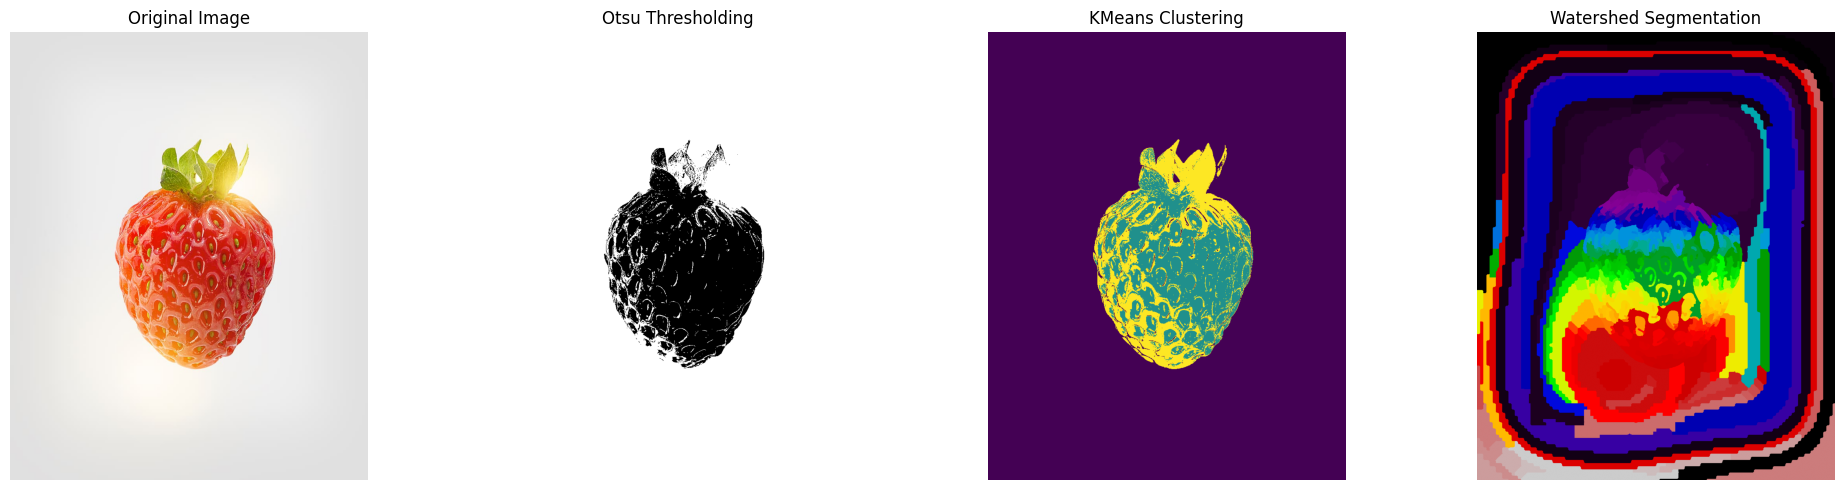

In [21]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import h_maxima
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np

# Load image
image = imread('strawberry.jpg')
gray = rgb2gray(image)

# --- 1. Otsu Thresholding ---
thresh_otsu = threshold_otsu(gray)
binary_otsu = gray > thresh_otsu

# --- 2. KMeans Clustering (3 clusters) ---
pixels = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=3, random_state=0).fit(pixels)
seg_kmeans = kmeans.labels_.reshape(image.shape[:2])

# --- 3. Watershed ---
gradient = ndi.gaussian_gradient_magnitude(gray, sigma=2)

# h_maxima digunakan untuk mendeteksi puncak lokal sebagai penanda
hmax = h_maxima(-gradient, h=0.01)
markers = ndi.label(hmax)[0]

# Terapkan watershed
labels_ws = watershed(gradient, markers=markers, mask=gray > 0.1)

# --- Plot Results ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(binary_otsu, cmap='gray')
axes[1].set_title("Otsu Thresholding")
axes[1].axis('off')

axes[2].imshow(seg_kmeans, cmap='viridis')
axes[2].set_title("KMeans Clustering")
axes[2].axis('off')

axes[3].imshow(labels_ws, cmap='nipy_spectral')
axes[3].set_title("Watershed Segmentation")
axes[3].axis('off')

plt.tight_layout()
plt.show()